# Background fit 

### Non-Resonant background 

In [23]:
import uproot
import awkward as ak
from vector import Array as awk
import numpy as np

# Path to the ROOT file and tree
file_path_signal = "../../../output_root/v2_production/backgrounds/GJetPt40.root"
tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"


# Load the ROOT file and extract variables
with uproot.open(file_path_signal) as file:
    tree = file[tree_name]
    
    # Extract b-jet variables
    lead_bjet_pt = tree["Res_lead_bjet_pt"].array(library="ak")    # Transverse momentum of leading b-jet
    lead_bjet_eta = tree["Res_lead_bjet_eta"].array(library="ak")  # Pseudorapidity of leading b-jet
    lead_bjet_phi = tree["Res_lead_bjet_phi"].array(library="ak")  # Azimuthal angle of leading b-jet
    lead_bjet_mass = tree["Res_lead_bjet_mass"].array(library="ak") # Mass of leading b-jet

    sublead_bjet_pt = tree["Res_sublead_bjet_pt"].array(library="ak")    # Transverse momentum of subleading b-jet
    sublead_bjet_eta = tree["Res_sublead_bjet_eta"].array(library="ak")  # Pseudorapidity of subleading b-jet
    sublead_bjet_phi = tree["Res_sublead_bjet_phi"].array(library="ak")  # Azimuthal angle of subleading b-jet
    sublead_bjet_mass = tree["Res_sublead_bjet_mass"].array(library="ak") # Mass of subleading b-jet

    # Extract dijet variables
    dijet_pt = tree["Res_dijet_pt"].array(library="ak")    # Transverse momentum of the dijet system
    dijet_eta = tree["Res_dijet_eta"].array(library="ak")  # Pseudorapidity of the dijet system
    dijet_phi = tree["Res_dijet_phi"].array(library="ak")  # Azimuthal angle of the dijet system
    dijet_mass = tree["Res_dijet_mass"].array(library="ak") # Mass of the dijet system
    
    bbgg_mass = tree["Res_HHbbggCandidate_mass"].array(library="ak")


# Load the ROOT file and extract variables
with uproot.open(file_path_signal) as file:
    tree = file[tree_name]
    lead_pho_pt = tree["lead_pt"].array(library="ak")
    lead_pho_eta = tree["lead_eta"].array(library="ak")
    lead_pho_phi = tree["lead_phi"].array(library="ak")
    sublead_pho_pt = tree["sublead_pt"].array(library="ak")
    sublead_pho_eta = tree["sublead_eta"].array(library="ak")
    sublead_pho_phi = tree["sublead_phi"].array(library="ak")

# Define the lVector function
def lVector(pt1, eta1, phi1, pt2, eta2, phi2, mass1=0, mass2=0):
    lvec_1 = awk(
        ak.zip({"pt": pt1, "eta": eta1, "phi": phi1, "mass": ak.full_like(pt1, mass1)})
    )
    lvec_2 = awk(
        ak.zip({"pt": pt2, "eta": eta2, "phi": phi2, "mass": ak.full_like(pt2, mass2)})
    )
    lvec_ = lvec_1 + lvec_2
    return lvec_

# Compute the diphoton Lorentz vector
diphoton_ = lVector(
    lead_pho_pt,
    lead_pho_eta,
    lead_pho_phi,
    sublead_pho_pt,
    sublead_pho_eta,
    sublead_pho_phi,
)


# Compute diphoton mass from its Lorentz vector
diphoton_mass = diphoton_.mass


diphoton_mass_np = ak.to_numpy(diphoton_mass)

# Convert extracted variabless to NumPy arrays
bbgg_mass_np = ak.to_numpy(bbgg_mass)
# dibjet_mass_np = ak.to_numpy(dibjet_mass)

# Compute reduced_mass
reduced_mass = bbgg_mass_np - (diphoton_mass_np - 125) - (dijet_mass - 125)

## Fitting backgrounds

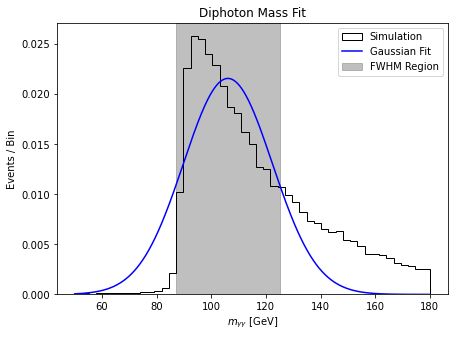

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uproot
import awkward as ak
from vector import Array as awk

# Load the ROOT file and extract diphoton mass
# file_path_signal = "/mnt/data/GJetPt40.root"  # Update this if needed
# tree_name = "DiphotonTree/data_125_13TeV_NOTAG/"



# Define Gaussian fit function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Create histogram
bins = np.linspace(50, 180, 50)  # Adjust as needed
hist, bin_edges = np.histogram(diphoton_mass, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit the histogram data with a Gaussian
popt, _ = curve_fit(gaussian, bin_centers, hist, p0=[0.01, 125, 10])

# Generate smooth Gaussian curve
x_fit = np.linspace(50, 180, 1000)
y_fit = gaussian(x_fit, *popt)

# Calculate FWHM
sigma = popt[2]
mu = popt[1]
fwhm_low, fwhm_high = mu - sigma * np.sqrt(2 * np.log(2)), mu + sigma * np.sqrt(2 * np.log(2))

# Plot
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit, color="blue", label="Gaussian Fit")
plt.axvspan(fwhm_low, fwhm_high, color='gray', alpha=0.5, label="FWHM Region")

plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Fit")
plt.show()


In [37]:
# Adjusted initial parameters for better fit
initial_guess = [0.01, 125, 1.5, 1.2, 3.0, 1.5, 3.0]  

# Fit using the adjusted parameters
popt_dscb, pcov_dscb = curve_fit(dscb_vectorized, bin_centers, hist, p0=initial_guess, maxfev=5000)

# Compute parameter errors (square root of diagonal elements of covariance matrix)
errors_dscb = np.sqrt(np.diag(pcov_dscb))

# Generate DSCB curve
y_fit_dscb = dscb_vectorized(x_fit, *popt_dscb)


/tmp/sraj/ipykernel_423361/3729669725.py:31: RuntimeWarning: invalid value encountered in double_scalars
  return A * ((n1 / abs_alpha1) ** n1) * np.exp(-0.5 * abs_alpha1**2) / ((n1 / abs_alpha1 - abs_alpha1 - t) ** n1)
/tmp/sraj/ipykernel_423361/3729669725.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return A * ((n2 / abs_alpha2) ** n2) * np.exp(-0.5 * abs_alpha2**2) / ((n2 / abs_alpha2 - abs_alpha2 + t) ** n2)
/tmp/sraj/ipykernel_423361/3729669725.py:35: RuntimeWarning: overflow encountered in double_scalars
  return A * ((n2 / abs_alpha2) ** n2) * np.exp(-0.5 * abs_alpha2**2) / ((n2 / abs_alpha2 - abs_alpha2 + t) ** n2)


In [38]:
from scipy.stats import norm

# Fit Gaussian
popt_gauss, _ = curve_fit(lambda x, A, mu, sigma: A * norm.pdf(x, mu, sigma), bin_centers, hist, 
                          p0=[0.01, 125, 2.0])

# Generate Gaussian curve
y_fit_gauss = popt_gauss[0] * norm.pdf(x_fit, popt_gauss[1], popt_gauss[2])


In [39]:
def chi_square(y_obs, y_exp, errors):
    return np.sum(((y_obs - y_exp) / errors) ** 2) / (len(y_obs) - len(popt_dscb))

# Estimate histogram uncertainties (Poisson errors)
errors_hist = np.sqrt(hist + 1e-6)  # Adding small value to avoid division by zero

# Compute Chi-square
chi2_dscb = chi_square(hist, dscb_vectorized(bin_centers, *popt_dscb), errors_hist)
chi2_gauss = chi_square(hist, popt_gauss[0] * norm.pdf(bin_centers, popt_gauss[1], popt_gauss[2]), errors_hist)

print(f"Reduced χ² (DSCB) = {chi2_dscb:.3f}")
print(f"Reduced χ² (Gaussian) = {chi2_gauss:.3f}")


Reduced χ² (DSCB) = 0.000
Reduced χ² (Gaussian) = 0.012


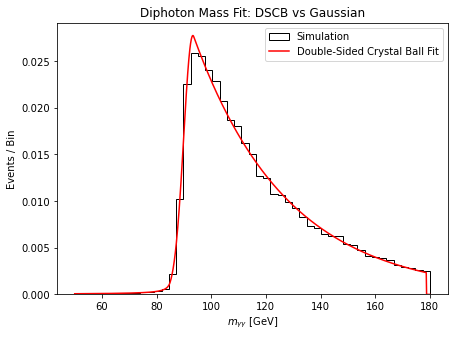

In [42]:
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit_dscb, color="red", label="Double-Sided Crystal Ball Fit")
# plt.plot(x_fit, y_fit_gauss, color="blue", linestyle="dashed", label="Gaussian Fit")

# plt.axvspan(fwhm_low, fwhm_high, color='gray', alpha=0.5, label="FWHM Region")

plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Fit: DSCB vs Gaussian")
plt.show()


### complete code 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import uproot
import awkward as ak
from vector import Array as awk

# Define the DSCB function
def double_sided_crystal_ball(x, A, mu, sigma, alpha1, n1, alpha2, n2):
    """
    Double-Sided Crystal Ball function.

    Parameters:
    - A: Normalization
    - mu: Mean
    - sigma: Standard deviation
    - alpha1: Transition point for left tail
    - n1: Power-law parameter for left tail
    - alpha2: Transition point for right tail
    - n2: Power-law parameter for right tail
    """
    t = (x - mu) / sigma
    abs_alpha1, abs_alpha2 = abs(alpha1), abs(alpha2)
    
    # Gaussian Core
    if -abs_alpha1 <= t <= abs_alpha2:
        return A * np.exp(-0.5 * t**2)

    # Left Power-law Tail
    elif t < -abs_alpha1:
        return A * ((n1 / abs_alpha1) ** n1) * np.exp(-0.5 * abs_alpha1**2) / ((n1 / abs_alpha1 - abs_alpha1 - t) ** n1)

    # Right Power-law Tail
    else:
        return A * ((n2 / abs_alpha2) ** n2) * np.exp(-0.5 * abs_alpha2**2) / ((n2 / abs_alpha2 - abs_alpha2 + t) ** n2)

# Vectorize function for fitting
dscb_vectorized = np.vectorize(double_sided_crystal_ball)
# Create histogram
bins = np.linspace(50, 180, 200)
hist, bin_edges = np.histogram(diphoton_mass, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guess for fit parameters
initial_guess = [0.01, 125, 2.0, 1.5, 2.0, 1.5, 2.0]

# Fit the histogram data with DSCB
popt, _ = curve_fit(dscb_vectorized, bin_centers, hist, p0=initial_guess, maxfev=5000)

# Generate DSCB curve
x_fit = np.linspace(50, 180, 200)
y_fit = dscb_vectorized(x_fit, *popt)

# Calculate FWHM
sigma, mu = popt[2], popt[1]
fwhm_low, fwhm_high = mu - sigma * np.sqrt(2 * np.log(2)), mu + sigma * np.sqrt(2 * np.log(2))

# Plot results
plt.figure(figsize=(7, 5))
plt.hist(diphoton_mass, bins=bins, density=True, histtype="step", color="black", label="Simulation")
plt.plot(x_fit, y_fit, color="red", label="Double-Sided Crystal Ball Fit")
# plt.axvspan(fwhm_low, fwhm_high, color='gray', alpha=0.5, label="FWHM Region")

plt.xlabel(r"$m_{\gamma\gamma}$ [GeV]")
plt.ylabel("Events / Bin")
plt.legend()
plt.title("Diphoton Mass Fit (Double-Sided Crystal Ball)")
plt.show()

### Resonant background

For resonant background, we consider all possible Higgs production mechanisms: gluon-gluon129
fusion (ggH), vector-boson fusion (VBFH), associated production with a vector boson (VH), top130
quarks (ttH), and b-quarks (bbH) where Higgs decays into two photons.131